# Homework 2 - Genetic Algorithm for Finding Function Maximum

## Abstract

We wish to find a maxima point for a function given as input.\
The function should be treated as a _black box_, meaning we can't use the knowledge of the matematical expression of the formula for find the maximal point.

For finding the optimal point we are going to perform a genetic evolution of a population, where each individual represents a potential point of maxima, using a base-2 encoding.
<img src="https://miro.medium.com/max/1838/1*BYDJpa6M2rzWNSurvspf8Q.png" alt="Genetic Evolution" style="width: 500px;"/>

## The Genetic Evolution

Each generation of the new population is obtained applying the following algorithm to the old generation:
* Select the top $p_1$ percent of the population (according to the individuals' fintnesses.
* Select an additional $p_2$ percent of the remaining population (using a proportional selection -- a higher fitness makes an individual more likely to be selected).
* Uniformly select individuals from the two previous selections, and add a mutated copy.
* Uniformly select pairs of individuals from the first two selections, and add cross-overs.


## Encoding

For this particular generic evolution instance, we have the following problem:

Given a function $F : [a, b] \to \mathbf{R}^+$, find a point of maxima, i.e. a number $a \leq x \leq b$ such that $\forall a \leq y \leq b,\ F(x) \geq F(y)$.

An individual of our population is simply a real number.\
The genome of the encoded number $x$ is choosen as being the representation in base $2$ of the number $x - a$. As such, the genome's representation will have $log_2((b - a + 1) * 10^{precision})$, where $precision$ is the number of decimals we want to include.

The fitness of a given individual is simply the value of the function $F$ in the given point.

## Including Used Libraries

For this notebook I used:
 * `Numpy` - useful for advanced computations
 * `matplotlib` - library used for plotting graphs
 * `ipywidgets` - library containing interactive widgets
 * `math`, `random` - standard `Python` libraries

In [1]:
# Including usefull modules.
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
import math, random

## Definining Global Variables

The variables we store are:
* `fn_to_maximize`, a function $f: \mathbf{R} \to \mathbf{R}$ we want to maximize.
* `range_of_fn`, a tuple $\in \mathbf{Z} \times \mathbf{Z}$, the domain of function $f$.
* `number_of_generations`, a positive number storing the required number of generations.
* `size_of_population`, a positive number storing the size of each population.
* `precision`, a number storing the required decimal precision of the answer.
* `p_mutation`, a real number in $[0, 1]$ storing the probability of a mutation.
* `pozitive_bits` and `decimal_bits`, storing the number of positive and decimal bits in the genome.
* `number_of_elite_survivors` means that the top x individuals will survive.
* `number_of_normal_survivors` means that x individuals will survive, with proportional probabilities.
* `number_of_numtation`, the number of mutations each generation gets.
* `display_verbose_info` is a flag to see if we have to display additional informations.

In [2]:
# Global variables.
fn_to_maximize = None
range_of_fn = None
number_of_generations = None
size_of_population = None
precision = None
p_mutation = None
pozitive_bits, decimal_bits = None, None
number_of_elite_survivors = None
number_of_normal_survivors = None
number_of_mutations = None
display_verbose_info = None
show_mutations_details = None
show_choices_details = None

## Helper Functions

These functions help us through the different phases of the genetic evolution.

In [70]:
# Helper functions.
def ComputeBitLengths():
    """
        Computes the `pozitive_bits` and `decimal_bits` global variables.
    """
    global pozitive_bits, decimal_bits

    pozitive_bits = (range_of_fn[1] - range_of_fn[0] + 1).bit_length()
    decimal_bits = (10**precision).bit_length() + 1
    
    if display_verbose_info:
        print(("As the values range from %d to %d, I decided to use %d" +
               " digits,\nfrom which %d are for the integer value and %d" +
               " are for the decimals.\n\n") % (range_of_fn[0], range_of_fn[1],
                                               pozitive_bits + decimal_bits,
                                               pozitive_bits, decimal_bits))

def ConvertChromosomeToNumber(chromosome: list):
    """
        Converts a chromosome into a number.
    """
    assert(len(chromosome) == pozitive_bits + decimal_bits)
    ans = 0.

    for d in range(pozitive_bits):
        ans += chromosome[pozitive_bits - d - 1] << d

    mul = 1 / 2
    for d in range(decimal_bits):
        ans += chromosome[pozitive_bits + d] * mul
        mul /= 2
    
    return ans + range_of_fn[0]

def DisplayChromosome(chromosome: list):
    """
        This function transforms a chromosome into a string.
    """
    return "".join([str(x) for x in chromosome])

def FitnessOfChromosome(chromosome: list):
    """
        Returns the numerical value (fitness) of a chromosome.
    """
    associated_number = ConvertChromosomeToNumber(chromosome)

    # Not in range.
    if not range_of_fn[0] <= associated_number <= range_of_fn[1]:
        return 0
    ans = fn_to_maximize(associated_number)
    if ans < 0:
        raise "Point " + str(associated_number) + " yields value " +\
                str(ans) + " which is negative!"
    return ans

def FitnessOfChromosomes(chromosomes: list):
    """
        Returns a list of fitnesses.
    """
    return [FitnessOfChromosome(x) for x in chromosomes]

def FitnessOfList(chromosomes: list):
    """
        Returns best fitness of a list.
    """
    return max(map(FitnessOfChromosome, chromosomes))

def MutationOfChromosome(chromosome: list):
    """
        Returns a mutation of the chromosome
    """

    # Copy chromosome.
    ans = [x for x in chromosome]

    # Perform mutations.
    for i in range(len(ans)):
        if random.random() < p_mutation:
            ans[i] ^= 1
    
    if show_mutations_details:
        print("  Mutated genome " + DisplayChromosome(chromosome) +
              " into " + DisplayChromosome(ans))
    return ans

def CrossOverOfChromosomes(chromosome1: list, chromosome2: list):
    """
        Returns a new chromosome obtained by a crossing of the two.
    """
    where = random.randint(0, pozitive_bits + decimal_bits)
    ans = chromosome1[:where] + chromosome2[where:]
    
    if show_mutations_details:
        print("  Crossed " + DisplayChromosome(chromosome1) + " and " +
              DisplayChromosome(chromosome2) + " at " + str(where) + " into " +
              DisplayChromosome(ans))
    
    return ans

def GenerateRandomPopulation():
    """
        Returns a random population.
    """
    p = None
    
    while p is None or FitnessOfList(p) == 0:
        p = np.random.randint(0, 2, (size_of_population, pozitive_bits + decimal_bits)).tolist()
    
    return p

def ProportionalChoice(chromosomes: list, nr: int):
    """
        Returns a random choice of chromosomes, using the ruler's rule.
    """
    weights = FitnessOfChromosomes(chromosomes)
    s = sum(weights)
    weights = [x / s for x in weights]

    items = np.random.choice(len(chromosomes), nr, p=weights)
    if show_choices_details:
        print("  Performed a proportional choice:")
        print("   * Number of items: %d" % len(chromosomes))
        print("   * Number of items to select: %d" % nr)
        print("   * Individuals:")
        for i in chromosomes:
            print("      * %s with fitness of %f (%f%%)" %
                  (DisplayChromosome(i), FitnessOfChromosome(i), FitnessOfChromosome(i) / s * 100))
        print("   * Choosen chromosomes:")
        for nr, i in enumerate(items):
            print("      * Chromosome #%d - %s with fitness of %f" %
                (nr, DisplayChromosome(chromosomes[i]), FitnessOfChromosome(chromosomes[i])))
    return [chromosomes[int(x)] for x in items]

def NormalChoice(chromosomes: list, nr: int):
    """
        Returns a random choice of chromosomes, taken uniformly.
    """
    items = np.random.choice(len(chromosomes), nr)
    if show_choices_details:
        print("  Performed a uniform choice:")
        print("   * Number of items: %d" % len(chromosomes))
        print("   * Number of items to select: %d" % nr)
        print("   * Individuals:")
        for i in chromosomes:
            print("      * %s with fitness of %f" % (DisplayChromosome(i), FitnessOfChromosome(i)))
        print("   * Choosen chromosomes:")
        for nr, i in enumerate(items):
            print("      * Chromosome #%d - %s with fitness of %f" %
                (nr, DisplayChromosome(chromosomes[i]), FitnessOfChromosome(chromosomes[i])))
    return [chromosomes[int(x)] for x in items]
    
def SortByFitness(chromosomes: list):
    """
        Sorts a chromosome by fitness, descending.
    """
    order = np.argsort(FitnessOfChromosomes(chromosomes)).tolist()
    return [chromosomes[x] for x in order][::-1]

## Statistics and Plots

These functions help compute statistics and plot graphs of the evolution.

In [71]:
best_fitness_history = None
average_fitness_history = None
average_fitness_cross_over_history = None
average_fitness_mutations_over_history = None

def ResetHistory():
    """
        This function resets the history arrays.
    """
    global best_fitness_history
    global average_fitness_cross_over_history
    global average_fitness_history
    global average_fitness_mutations_over_history

    best_fitness_history = []
    average_fitness_history = []
    average_fitness_cross_over_history = [0]
    average_fitness_mutations_over_history = [0]


def AddHistoryToPopulation(population: list):
    """
        This function updates the history of maximal and average
        fitness over the population.
    """
    best_fitness_history.append(FitnessOfList(population))
    average_fitness_history.append(
        sum(FitnessOfChromosomes(population)) / len(population)
    )

def AddHistoryToMutations(mutated_population: list):
    """
        This function update the mutated population's history.
    """
    average_fitness_mutations_over_history.append(
        sum(FitnessOfChromosomes(mutated_population)) / len(mutated_population)
    )


def AddHistoryToCrossings(crossed_population: list):
    """
        This function update the crossed population's history.
    """
    average_fitness_cross_over_history.append(
        sum(FitnessOfChromosomes(crossed_population)) / len(crossed_population)
    )

def PlotHistory():
    """
        This function plots the history evolution.
    """
    plt.figure(figsize=(15, 6)) 
    plt.plot(best_fitness_history, label="Best Fitness")
    plt.plot(average_fitness_history, label="Average Fitness")
    plt.plot(average_fitness_cross_over_history, label="Average Fitness of Crossings")
    plt.plot(average_fitness_mutations_over_history, label="Average Fitness of Mutations")
    plt.legend()
    plt.show()
    

## Show Informations About Result

This function displays results about the final population.

In [72]:
def ShowInfo(population: list):
    """
        This functions shows results about the final population.
    """
    best_item = int(np.argmax(FitnessOfChromosomes(population)))
    print("\n\nThe best individual has the following genome:", end='')
    genome = "".join([str(x) for x in population[best_item]])
    for i, c in enumerate(genome):
        if i % 30 == 0:
            print("\n    ", end='')
        print(c, end='')
    print('\n')
    val = ConvertChromosomeToNumber(population[best_item])
    print("The interpretation of the genome as a number is", val)
    print("The value of the function at the given point is F(" + str(val) + ") =", fn_to_maximize(val))

In [73]:
def Describe(chromosome: list):
    """
        Gives a description of the chromosome.
    """
    asociated_number = ConvertChromosomeToNumber(chromosome)
    string = DisplayChromosome(chromosome)
    fitness = FitnessOfChromosome(chromosome)
    return string + " - value of " + str(round(asociated_number, 3)) +\
            " and fitness of " + str(round(fitness, 3))

## Generic Evolution

This function performs the genetic evolution of the individuals.

In [68]:
def Compute(show_plot: bool):
    """
        This function performs the genetic evolution.
    """
    ComputeBitLengths()
    ResetHistory()

    population = GenerateRandomPopulation()
    
    if display_verbose_info:
        print("Generated initial population. Best fitness is", FitnessOfList(population))

    AddHistoryToPopulation(population)

    # Go through each generation.
    for gen in range(number_of_generations):
        if display_verbose_info:
            print("Processing generation #%d ... " % gen)
        else:
            print("#%d" % gen, end=' ')

        # Sort population by fitness.
        population = SortByFitness(population)

        # Add best number_of_elite_survivors items, and remove them
        # from the `population` list.
        elite_population = population[:number_of_elite_survivors]
        population = population[number_of_elite_survivors:]
        
        # Extract the "lucky" population by performing a proportional choice
        # of the remaining population.
        lucky_population = ProportionalChoice(population, number_of_normal_survivors)
        
        # The new "raw" population will be the elite + the lucky chromosomes.
        new_raw_population = elite_population + lucky_population

        # Choose uniformly which chromosomes of the raw population to mutate.
        items_to_mutate = NormalChoice(new_raw_population, number_of_mutations)

        mutated = [MutationOfChromosome(x) for x in items_to_mutate]
        new_raw_population += mutated
        
        # Choose uniformly which chromosomes of the raw population to cross over.
        cross_overs = [
            NormalChoice(
                new_raw_population,
                size_of_population - len(new_raw_population)
            )
            for _ in range(2)
        ]

        crosses = []

        for i in range(len(cross_overs[0])):
            crosses.append(
                CrossOverOfChromosomes(cross_overs[0][i], cross_overs[1][i])
            )
        
        new_raw_population += crosses

        
        # Update graphs.
        AddHistoryToMutations(mutated)
        AddHistoryToCrossings(crosses)
        AddHistoryToPopulation(new_raw_population)

        if display_verbose_info:
            print("  Best fitness is", FitnessOfList(new_raw_population))
            print("  Average fitness is",
                  sum(FitnessOfChromosomes(new_raw_population)) / len(new_raw_population))
            print("  Breakdown of the population:")
            print("    * Chromosomes kept as elite:")
            for nr, val in enumerate(elite_population):
                print(("        %d. " + Describe(val)) % nr)
            print("    * Chromosomes kept as lucky:")
            for nr, val in enumerate(lucky_population):
                print(("        %d. " + Describe(val)) % nr)
            print("    * Chromosomes obtained as mutations:")
            for nr, val in enumerate(mutated):
                print(("        %d. " + Describe(val)) % nr)
            print("    * Chromosomes obtained as cross-overs:")
            for nr, val in enumerate(crosses):
                print(("        %d. " + Describe(val)) % nr)
            print("\n=================================================\n")
        
        # Update the population.
        population = new_raw_population

    
    ShowInfo(population)

    if show_plot:
        PlotHistory()

## Running The Code

This portion of code is mainly using `ipywidgets` in order to offer an interactive way to change hyperparameters.

In [49]:
# Styling for displaying items in 2 rows.
style_wid = {'description_width': 'initial'}
full_layout_wid = Layout(width='80%', height='30px')
half_layout_wid = Layout(width='40%')

# Sliders and boxes for getting input.
number_of_generations_wid = BoundedIntText(
    description="Number of Generations",
    value=50, min=2, max=int(1e8),
    style=style_wid,
    layout=half_layout_wid
)
size_of_population_wid = BoundedIntText(
    description="Population Size",
    value=100, min=30, max=int(1e8),
    style=style_wid,
    layout=half_layout_wid
)
percentage_of_elite_survivors_wid = FloatSlider(
    description="Percentage of Elite Survivors",
    value=0.2, min=0.05, max=0.5,
    style=style_wid,
    layout=half_layout_wid,
    step=1e-4
)
percentage_of_normal_survivors_wid = FloatSlider(
    description="Percentage of Normal Survivors",
    value=0.1, min=0., max=0.5,
    style=style_wid,
    layout=half_layout_wid,
    step=1e-4
)
function_to_maximize_wid = Textarea(
    description="Function to maximize: f(x) = ",
    value="x ** 2 + 2 * x + 1",
    layout=full_layout_wid,
    style=style_wid
)
interval_for_function_wid = IntRangeSlider(
    description="Value Range for function f(x)",
    min=-1000, max=1000, value=[-10, 10],
    layout=full_layout_wid,
    style=style_wid
)
number_of_digits_wid = BoundedIntText(
    description="Precision (number of decimals)",
    value=3, min=0, max=100,
    style=style_wid,
    layout=half_layout_wid
)
probability_of_mutation_wid = FloatSlider(
    description="Probability of mutations:",
    value=0.3, min=0.01, max=0.5,
    style=style_wid,
    layout=half_layout_wid,
    step=1e-4
)
percentage_of_added_mutation_wid = FloatSlider(
    description="Mutation Percentage in new Population",
    value=0.5, min=0.1, max=0.9,
    style=style_wid,
    layout=half_layout_wid,
    step=1e-4
)
verbose_evolution_wid = Checkbox(
    value=False,
    description='Show Detailed Evolution',
    disabled=False,
    indent=False,
    style=style_wid,
    layout=Layout(width='20%')
)
plot_evolution_wid = Checkbox(
    value=True,
    description='Show Evolution Plot',
    disabled=False,
    indent=False,
    style=style_wid,
    layout=Layout(width='20%')
)
display_mutations_and_crossings_wid = Checkbox(
    value=False,
    description='Show Mutation and Crossings Details',
    disabled=False,
    indent=False,
    style=style_wid,
    layout=half_layout_wid
)
display_choices_wid = Checkbox(
    value=False,
    description='Show Randomized Choices Results',
    disabled=False,
    indent=False,
    style=style_wid,
    layout=Layout(width='30%')
)
# Rare mutation
# Display mutations and crossings
# Display choices

# Horizontal containers.
h_box1_wid = HBox([number_of_generations_wid, number_of_digits_wid])
h_box2_wid = HBox([size_of_population_wid, probability_of_mutation_wid])
h_box3_wid = HBox([percentage_of_elite_survivors_wid, percentage_of_normal_survivors_wid])
h_box4_wid = HBox([percentage_of_added_mutation_wid, verbose_evolution_wid, plot_evolution_wid])
h_box5_wid = HBox([display_mutations_and_crossings_wid, display_choices_wid])

# Display horizontal boxes in a vertical box.
box_wid = VBox([
    function_to_maximize_wid,
    interval_for_function_wid,
    h_box1_wid,
    h_box2_wid,
    h_box3_wid,
    h_box4_wid,
    h_box5_wid
])

# Display widgets.
display(box_wid)

def StartComputation():
    global fn_to_maximize, range_of_fn, number_of_generations
    global precision, p_mutation, size_of_population
    global number_of_elite_survivors, number_of_normal_survivors
    global number_of_mutations, display_verbose_info
    global show_mutations_details, show_choices_details
    
    fn_to_maximize = lambda x: eval(function_to_maximize_wid.value, None, {"x": x})
    value = fn_to_maximize(1.)
    if type(value) is not float:
        raise "Expression not valid!"
    
    show_mutations_details = display_mutations_and_crossings_wid.value
    show_choices_details = display_choices_wid.value
    range_of_fn = interval_for_function_wid.value
    number_of_generations = number_of_generations_wid.value
    precision = number_of_digits_wid.value
    p_mutation = probability_of_mutation_wid.value
    size_of_population = size_of_population_wid.value
    number_of_elite_survivors = max(1, int(np.floor(percentage_of_elite_survivors_wid.value *
                                                    size_of_population)))
    number_of_normal_survivors = int(np.floor((size_of_population - number_of_elite_survivors) *
                                              percentage_of_normal_survivors_wid.value))
    number_of_mutations =\
            int(np.ceil((size_of_population - number_of_elite_survivors - number_of_normal_survivors) *
                                percentage_of_added_mutation_wid.value))

    show_plot = plot_evolution_wid.value
    display_verbose_info = verbose_evolution_wid.value

    Compute(show_plot)

## Meaning of the parameters

* `Function to maximize`: Function we wish the genetic algorithm to maximize.
* `Value Range for function` $f(x)$: Interval to search for a maximal value of $f(x)$.
* `Number of Generations`: Number of generations to compute during the genetic evolution.
* `Precision`: Number of decimals to consider when searching the optimal point.
* `Population Size`: Number of individuals at any given time for each generation.
* `Probability of mutations`: Probability of each gene being mutated at each mutation.
* `Percentage of Elite Survivors`: Percentage of the population kept unaltered as "elite" individuals.<br>
    The individuals kept are the ones with the highest fitness.
    
* `Percentage of Normal Survivors`: Percentage of the population (excepting the elite survivors) kept as "lucky" survivors.<br>
    The normal survivors are selected proportionaly to their fitness:<br>
    The probability of keeping an individual $x$ is $\frac{fitness_x}{\sum{fitness_i}}$
* `Mutation Percentage in new Population`: For new individuals (everyone except survivors), percentage comming from mutations and percentage comming from cross-overs.

#0 #1 #2 #3 #4 #5 #6 #7 #8 #9 #10 #11 #12 #13 #14 #15 #16 #17 #18 #19 #20 #21 #22 #23 #24 #25 #26 #27 #28 #29 #30 #31 #32 #33 #34 #35 #36 #37 #38 #39 #40 #41 #42 #43 #44 #45 #46 #47 #48 #49 #50 #51 #52 #53 #54 #55 #56 #57 #58 #59 #60 #61 #62 #63 #64 #65 #66 #67 #68 #69 #70 #71 #72 #73 #74 #75 #76 #77 #78 #79 #80 #81 #82 #83 #84 #85 #86 #87 #88 #89 #90 #91 #92 #93 #94 #95 #96 #97 #98 #99 #100 #101 #102 #103 #104 #105 #106 #107 #108 #109 #110 #111 #112 #113 #114 #115 #116 #117 #118 #119 #120 #121 #122 #123 #124 #125 #126 #127 #128 #129 #130 #131 #132 #133 #134 #135 #136 #137 #138 #139 #140 #141 #142 #143 #144 #145 #146 #147 #148 #149 #150 #151 #152 #153 #154 #155 #156 #157 #158 #159 #160 #161 #162 #163 #164 #165 #166 #167 #168 #169 #170 #171 #172 #173 #174 #175 #176 #177 #178 #179 #180 #181 #182 #183 #184 #185 #186 #187 #188 #189 #190 #191 #192 #193 #194 #195 #196 #197 #198 #199 #200 #201 #202 #203 #204 #205 #206 #207 #208 #209 #210 #211 #212 #213 #214 #215 #216 #217 #218 #219 #220 #221 

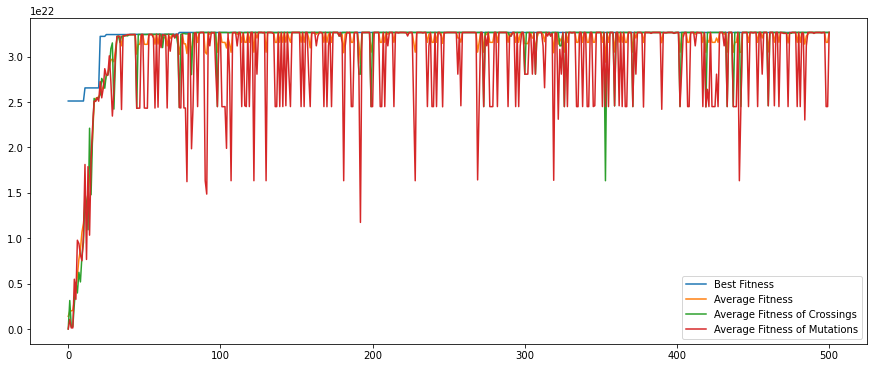

In [78]:
StartComputation()